#### Importing libraries

In [1]:
from sklearn.metrics import f1_score
import json
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib as plt
import re

#### Data preprocessing

In [2]:
# Some json stuffs
file = 'Cell_Phones_and_Accessories_5.json'

reviews = []
try:
    with open(file) as f:
        for l in f:
            review = json.loads(l)
            reviews.append((review['reviewText'],review['overall']))
except: KeyError #because file's size is big


In [3]:
df = pd.DataFrame(reviews)
df.columns = ['review','overall']
df

,review,overall
0,Looks even better in person. Be careful to not...,5.0
1,When you don't want to spend a whole lot of ca...,5.0
2,"so the case came on time, i love the design. I...",3.0
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,2.0
4,"I liked it because it was cute, but the studs ...",4.0
...,...,...
13586,I didn't want to attach a clip to my iphone di...,4.0
13587,Very happy with the product and service. I wo...,5.0
13588,Does not lock oh I do not use it anymore !,2.0
13589,These things are great.,5.0


In [4]:
# creating sentiment column Positive,Negative,Neutral
df['sentiment'] = df['overall'].apply(lambda x:'Positive' if x>=4 else ('Negative' if x<=2 else 'Neutral'))

In [5]:
df

,review,overall,sentiment
0,Looks even better in person. Be careful to not...,5.0,Positive
1,When you don't want to spend a whole lot of ca...,5.0,Positive
2,"so the case came on time, i love the design. I...",3.0,Neutral
3,DON'T CARE FOR IT. GAVE IT AS A GIFT AND THEY...,2.0,Negative
4,"I liked it because it was cute, but the studs ...",4.0,Positive
...,...,...,...
13586,I didn't want to attach a clip to my iphone di...,4.0,Positive
13587,Very happy with the product and service. I wo...,5.0,Positive
13588,Does not lock oh I do not use it anymore !,2.0,Negative
13589,These things are great.,5.0,Positive


In [6]:
df['sentiment'].value_counts()

Positive    9734
Negative    2397
Neutral     1460
Name: sentiment, dtype: int64

In [7]:
# converting onject to category
cat_type = CategoricalDtype(categories = ['Negative','Neutral','Positive'])
df['sentiment'] = df['sentiment'].astype(cat_type)

In [8]:
#  evenly distubruted column for each rating
df=df.groupby('sentiment', as_index=False, group_keys=False).apply(lambda x: x.sample(n=1200))
df

,review,overall,sentiment
8102,The telephone would not recognize the sim card...,1.0,Negative
8478,I picked this up to use with my Galaxy Note 3 ...,2.0,Negative
2006,The Motorola RAZR V3 is worst cell phone I hav...,2.0,Negative
11361,Came in Spanish programming. Can't read it. Go...,1.0,Negative
4758,"Beautiful case, but the clip is just no good. ...",1.0,Negative
...,...,...,...
2602,This phone does every thing I could want from ...,5.0,Positive
2923,After going through a few headsets that were l...,5.0,Positive
1561,"just to be clear, you need this if you have an...",5.0,Positive
5181,"Awww I collect snowmen, and now I have a snoww...",5.0,Positive


In [9]:
# randomizing sentiment
#df.apply(lambda x: x.sample(frac=1).values)
#df

In [10]:
df['sentiment'].value_counts()

Positive    1200
Neutral     1200
Negative    1200
Name: sentiment, dtype: int64

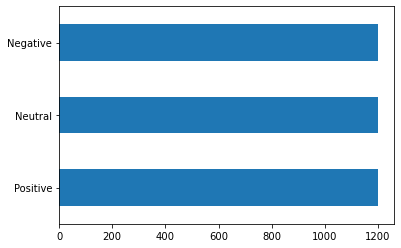

In [11]:
df['sentiment'].value_counts().plot.barh();

In [12]:
X = df['review']
y = df['sentiment']

In [13]:
X = X.apply(lambda x:x.lower())

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,test_size=.3)

In [15]:
X_train

4322      fits my husband's old style flip phone perfectly
13039    this antenna was shipped in bad packaging and ...
6903     ver high quality finish and feel to it.  it wo...
6129     arrived with inoperable indoor antenna, compan...
10869                                   works as expected.
                               ...                        
2892     i bought this thinking i was going to get an u...
10915    the batteries are not genuine ones. but they a...
501                    the adhesive breaks fairly quickly.
6826     i work for an on-call computer service. i neve...
5790     i have trouble with phone cases but this one i...
Name: review, Length: 2520, dtype: object

In [16]:
y_train

4322     Positive
13039    Negative
6903     Positive
6129      Neutral
10869    Positive
           ...   
2892     Negative
10915     Neutral
501      Negative
6826     Positive
5790     Positive
Name: sentiment, Length: 2520, dtype: category
Categories (3, object): [Negative, Neutral, Positive]

#### Vectorization with TfidfVectorizer

In [17]:
vectorizer = TfidfVectorizer()
X_vectorized_train = vectorizer.fit_transform(X_train)
X_vectorized_test = vectorizer.transform(X_test)
print(X_vectorized_train)

  (0, 6178)	0.36588403458588764
  (0, 6226)	0.15442697825775165
  (0, 3452)	0.43485558533633306
  (0, 8216)	0.42457429351983833
  (0, 5866)	0.3273412550823594
  (0, 4223)	0.5050667074490482
  (0, 5574)	0.1372559489696146
  (0, 3405)	0.3030422396719509
  (1, 3968)	0.08969875502093347
  (1, 9429)	0.05231381634115032
  (1, 9571)	0.07507831643869822
  (1, 5217)	0.15086258883812298
  (1, 86)	0.09178545156469427
  (1, 9074)	0.05174004204504865
  (1, 6675)	0.06874517891297514
  (1, 2015)	0.12737678805108968
  (1, 4533)	0.06845760240727482
  (1, 8550)	0.061758600249648785
  (1, 9521)	0.11029908971198084
  (1, 6286)	0.0863316121145369
  (1, 7695)	0.1587719641337325
  (1, 5955)	0.05130076838285184
  (1, 8164)	0.1587719641337325
  (1, 7854)	0.043549986803710514
  (1, 5765)	0.06149045967467846
  :	:
  (2519, 3996)	0.0471221660051265
  (2519, 4587)	0.11592570676944537
  (2519, 7804)	0.08647643173793837
  (2519, 9568)	0.06633203156028904
  (2519, 1014)	0.07609395546234067
  (2519, 1541)	0.0587230331

#### Logistic regression

In [18]:
loj = LogisticRegression()
loj_model=loj.fit(X_vectorized_train,y_train)

In [19]:
y_pred_loj = loj_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,loj_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_loj,y_test))

f1_score:  [0.71891892 0.59084605 0.72103004]
accuracy_score:  0.6768518518518518


#### Neural networks


In [20]:
#### Some standartizating for neural net
scaler = StandardScaler(with_mean=False)
scaler_model = scaler.fit(X_vectorized_train)
X_scaled_train = scaler.transform(X_vectorized_train)
X_scaled_test = scaler.transform(X_vectorized_test)

In [21]:
mlpc = MLPClassifier(alpha=0.2,hidden_layer_sizes = (100,50,150))
mlpc_model = mlpc.fit(X_scaled_train,y_train)

In [22]:
y_pred_mlcp = mlpc_model.predict(X_scaled_test)
print('f1_score: ',f1_score(y_test,mlpc_model.predict(X_scaled_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_mlcp,y_test))

f1_score:  [0.61581137 0.53754941 0.58235294]
accuracy_score:  0.5777777777777777


#### K-nearest neighbor

In [23]:
knn = KNeighborsClassifier(n_neighbors = 50)
knn_model = knn.fit(X_vectorized_train,y_train)


In [24]:
y_pred_knn = knn_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,knn_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_knn,y_test))

f1_score:  [0.47619048 0.49311927 0.60571429]
accuracy_score:  0.525


#### Support vector machine


In [25]:
svc = SVC()
svc_model = svc.fit(X_vectorized_train,y_train)

In [26]:
y_pred_svc = svc_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,svc_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_svc,y_test))

f1_score:  [0.73469388 0.61103634 0.72140762]
accuracy_score:  0.687962962962963


#### Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators = 500)
rf_model = rf.fit(X_vectorized_train,y_train)

In [28]:
y_pred_rf = rf_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,rf_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_rf,y_test))

f1_score:  [0.72751678 0.60217984 0.68135095]
accuracy_score:  0.6703703703703704


#### XGBoost

In [29]:
# !pip install xgboost
xgbt = XGBClassifier()
xgbt_model = xgbt.fit(X_vectorized_train,y_train)

In [30]:
y_pred_xgbt = xgbt_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,xgbt_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_xgbt,y_test))

f1_score:  [0.70588235 0.5907173  0.67902996]
accuracy_score:  0.6592592592592592


#### LightGBM

In [31]:
#pip install lightgbm
lgbm = LGBMClassifier()
lgb_model = lgbm.fit(X_vectorized_train,y_train)

In [32]:
y_pred_lgbm = lgb_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,lgb_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_lgbm,y_test))

f1_score:  [0.69354839 0.57545839 0.70155587]
accuracy_score:  0.6574074074074074


#### Compairing models

In [33]:
print('accuracy_score:Logistic regression -',accuracy_score(y_pred_loj,y_test))
print('accuracy_score:Neural networks -',accuracy_score(y_pred_mlcp,y_test))
print('accuracy_score:K-nearest neighbors -',accuracy_score(y_pred_knn,y_test))
print('accuracy_score:Support vector machines -',accuracy_score(y_pred_svc,y_test))
print('accuracy_score:XGBoost -',accuracy_score(y_pred_xgbt,y_test))
print('accuracy_score:LightGBM -',accuracy_score(y_pred_lgbm,y_test))

accuracy_score:Logistic regression - 0.6768518518518518
accuracy_score:Neural networks - 0.5777777777777777
accuracy_score:K-nearest neighbors - 0.525
accuracy_score:Support vector machines - 0.687962962962963
accuracy_score:XGBoost - 0.6592592592592592
accuracy_score:LightGBM - 0.6574074074074074


#### Tuning best models with GridSearchCV

#### SVM tuning

In [34]:
svc_params = {'C':[1,5],'gamma':[1,5]}
svc = SVC()
svc_cv_model = GridSearchCV(svc,svc_params,cv=5,n_jobs=-1,verbose=2)
svc_cv_model.fit(X_vectorized_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   42.0s finished


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 5], 'gamma': [1, 5]}, verbose=2)

In [35]:
svc_cv_model.best_params_

{'C': 5, 'gamma': 1}

In [36]:
svc = SVC(C = 1,gamma = 1)
svc_model = svc.fit(X_vectorized_train,y_train)

In [37]:
y_pred_svc = svc_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,svc_model.predict(X_vectorized_test),average=None))
print('accuracy_score:K-fold SVM ',accuracy_score(y_pred_svc,y_test))

f1_score:  [0.73469388 0.61290323 0.72246696]
accuracy_score:K-fold SVM  0.6888888888888889


#### LightGBM tuning

In [38]:
lgbm = LGBMClassifier()
lgbm_params = {'n_estimators':[100,500],
              'learning_rate':[0.1,0.01],
              'min_child_samples':[10,20]}

In [ ]:
lgbm_cv_model = GridSearchCV(lgbm,lgbm_params,cv=5,n_jobs=-1,verbose=2)
lgbm_cv_model.fit(X_vectorized_train,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  7.1min finished


In [ ]:
lgbm_cv_model.best_params_

In [ ]:
lgbm = LGBMClassifier(learning_rate = 0.1,min_child_samples = 10,n_estimators = 100)
lgb_model = lgbm.fit(X_vectorized_train,y_train)

In [ ]:
y_pred_lgbm = lgb_model.predict(X_vectorized_test)
print('f1_score: ',f1_score(y_test,lgb_model.predict(X_vectorized_test),average=None))
print('accuracy_score: ',accuracy_score(y_pred_lgbm,y_test))

#### Saving best model

In [ ]:
with open('review_classifier.pkl', 'wb') as f:
    pickle.dump(svc_cv_model, f)

#### Loading model

In [ ]:
with open('review_classifier.pkl','rb') as f:
    loaded_model = pickle.load(f)

In [ ]:
test = ['''We got these cords due to the reviews.
We have used Anker in the past, and their cords used the be great.
But, that has changed lately.
Their customer service has been helpful, but lately, the customer service has gone downhill quickly as well.
I got these at the end of last year, and now, one isn't working at all.
I am not even going to bother with customer service because the last time I tried,
they basically accused me of breaking my cords on purpose.
(WHY would I do that?!) It isn't worth the hassle. Look elsewhere''','''The cord and plugs appear to be heavy duty and much sturdier than standard cables.
The plug casing over the actual electronic connection that plugs into the iphone is too big to fit through the access port in my waterproof Cellever case.
It fits in the case (not waterproof) my wife uses so I don't know if it is just Cellever case I use or if it is all waterproof cases.
Cord really looks great and I like it, it is just a little oversized and won't fit my case, which is the reason for the overall rating of a 4''']

testv = vectorizer.transform(test)

In [ ]:
loaded_model.predict(testv)

In [ ]:
y_pred = loaded_model.predict(X_vectorized_test)
labels = np.unique(df['sentiment'])


cm = confusion_matrix(y_test,y_pred,labels=labels)
cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
cmd.plot();